Particle filter
===============

A basic particle filter tracking algorithm, using a uniformly
distributed step as motion model, and the initial target colour as
determinant feature for the weighting function. This requires an
approximately uniformly coloured object, which moves at a speed no
larger than stepsize per frame.

This implementation assumes that the video stream is a sequence of numpy
arrays, an iterator pointing to such a sequence or a generator
generating one. The particle filter itself is a generator to allow for
operating on real-time video streams.

In [3]:
#!python
from numpy import *
from numpy.random import *


def resample(weights):
  n = len(weights)
  indices = []
  C = [0.] + [sum(weights[:i+1]) for i in range(n)]
  u0, j = random(), 0
  for u in [(u0+i)/n for i in range(n)]:
    while u > C[j]:
      j+=1
    indices.append(j-1)
  return indices


def particlefilter(sequence, pos, stepsize, n):
  seq = iter(sequence)
  x = ones((n, 2), int) * pos                   # Initial position
  f0 = seq.next()[tuple(pos)] * ones(n)         # Target colour model
  yield pos, x, ones(n)/n                       # Return expected position, particles and weights
  for im in seq:
    np.add(x, uniform(-stepsize, stepsize, x.shape), out=x, casting="unsafe")  # Particle motion model: uniform step
    x  = x.clip(zeros(2), array(im.shape)-1).astype(int) # Clip out-of-bounds particles
    f  = im[tuple(x.T)]                         # Measure particle colours
    w  = 1./(1. + (f0-f)**2)                    # Weight~ inverse quadratic colour distance
    w /= sum(w)                                 # Normalize w
    yield sum(x.T*w, axis=1), x, w              # Return expected position, particles and weights
    if 1./sum(w**2) < n/2.:                     # If particle cloud degenerate:
      x  = x[resample(w),:]                     # Resample particles according to weights

The following code shows the tracker operating on a test sequence
featuring a moving square against a uniform background.

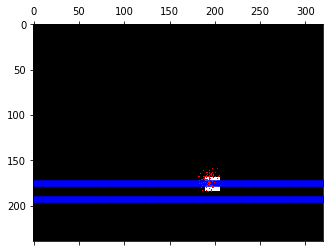

None

In [5]:
#!python
if __name__ == "__main__":
  from pylab import *
  from itertools import izip
  import time
  from IPython import display

  ion()
  seq = [ im for im in zeros((20,240,320), int)]      # Create an image sequence of 20 frames long
  x0 = array([120, 160])                              # Add a square with starting position x0 moving along trajectory xs
  xs = vstack((arange(20)*3, arange(20)*2)).T + x0
  for t, x in enumerate(xs):
    xslice = slice(x[0]-8, x[0]+8)
    yslice = slice(x[1]-8, x[1]+8)
    seq[t][xslice, yslice] = 255

  for im, p in izip(seq, particlefilter(seq, x0, 8, 100)): # Track the square through the sequence
    pos, xs, ws = p
    position_overlay = zeros_like(im)
    position_overlay[np.array(pos).astype(int)] = 1
    particle_overlay = zeros_like(im)
    particle_overlay[tuple(xs.T)] = 1
    draw()
    time.sleep(0.3)
    clf()                                           # Causes flickering, but without the spy plots aren't overwritten
    imshow(im,cmap=cm.gray)                         # Plot the image
    spy(position_overlay, marker='.', color='b')    # Plot the expected position
    spy(particle_overlay, marker=',', color='r')    # Plot the particles
    display.clear_output(wait=True)
    display.display(show())